In [1]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, VGG19, InceptionV3, InceptionResNetV2, VGG16
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers import SGD, RMSprop
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!nvidia-smi

Sat Apr 20 11:28:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.14                 Driver Version: 531.14       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 L...  WDDM | 00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8                4W /  N/A|      0MiB /  6141MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    validation_split=0.2  
)

In [12]:
train_img = train_datagen.flow_from_directory('train' ,class_mode='binary'
, batch_size=64 , subset="training",target_size=(32, 32) ,shuffle=True)
valid_img = train_datagen.flow_from_directory('train' ,class_mode='binary'
, batch_size=64 ,subset="validation", target_size=(32, 32),shuffle=True)

Found 80000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [13]:
print(train_img.class_indices)
print(valid_img.class_indices)

{'FAKE': 0, 'REAL': 1}
{'FAKE': 0, 'REAL': 1}


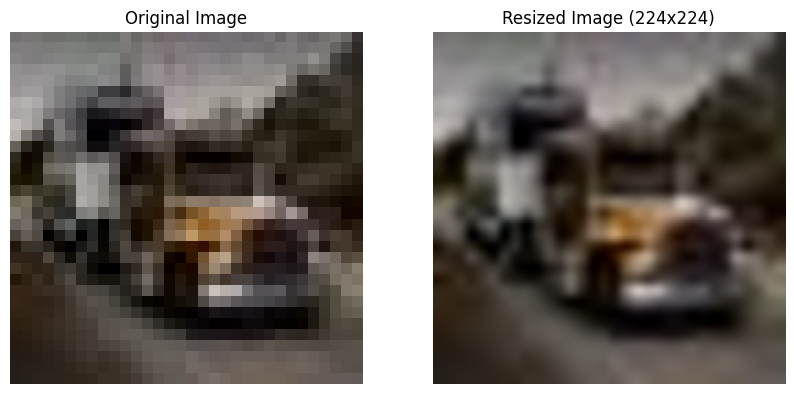

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the original image
im = Image.open("train/FAKE/1000 (10).jpg")

# Define the new size
new_size = (224, 224)

# Resize the image
im_resized = im.resize(new_size)

# Plot the original and resized images
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(im)
plt.title('Original Image')
plt.axis('off')

# Plot the resized image
plt.subplot(1, 2, 2)
plt.imshow(im_resized)
plt.title('Resized Image (224x224)')
plt.axis('off')

plt.show()

In [16]:
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
                                        input_tensor=Input(shape=(32, 32, 3)))



58889256/58889256 [==============================] - 14s 0us/step


In [17]:
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [18]:
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

modelVGG16 = Model(inputs=baseModel.input, outputs=headModel)

In [19]:
modelVGG16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [25]:
# opt = tf.keras.optimizers.SGD(learning_rate=0.001)
modelVGG16.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

In [26]:
history = modelVGG16.fit(train_img,
                    validation_data=valid_img,
                    epochs=7,callbacks=[callback]
)

Epoch 1/7
1250/1250 [==============================] - 1103s 881ms/step - loss: 0.3731 - accuracy: 0.8326 - precision_3: 0.8356 - recall_3: 0.8280 - val_loss: 0.2774 - val_accuracy: 0.8834 - val_precision_3: 0.8681 - val_recall_3: 0.9041
Epoch 2/7
1250/1250 [==============================] - 749s 599ms/step - loss: 0.2786 - accuracy: 0.8828 - precision_3: 0.8831 - recall_3: 0.8824 - val_loss: 0.2484 - val_accuracy: 0.8971 - val_precision_3: 0.8574 - val_recall_3: 0.9526
Epoch 3/7
1250/1250 [==============================] - 750s 600ms/step - loss: 0.2385 - accuracy: 0.9012 - precision_3: 0.9008 - recall_3: 0.9018 - val_loss: 0.2092 - val_accuracy: 0.9147 - val_precision_3: 0.9358 - val_recall_3: 0.8904
Epoch 4/7
1250/1250 [==============================] - 1093s 875ms/step - loss: 0.2135 - accuracy: 0.9121 - precision_3: 0.9113 - recall_3: 0.9130 - val_loss: 0.2360 - val_accuracy: 0.9010 - val_precision_3: 0.8512 - val_recall_3: 0.9721
Epoch 5/7
1250/1250 [=============================

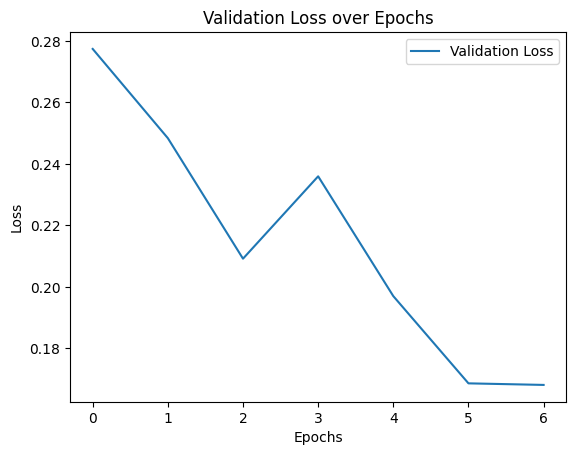

In [27]:
val_loss =history.history['val_loss']

# พล็อต validation loss
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()


In [29]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory('test', target_size=(32,32),
                                                  batch_size=64, class_mode='binary', shuffle=False)

Found 20000 images belonging to 2 classes.


In [30]:
scores = modelVGG16.evaluate(test_generator)

print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

313/313 [==============================] - 115s 369ms/step - loss: 0.1502 - accuracy: 0.9408 - precision_3: 0.9666 - recall_3: 0.9132
Baseline error: 0.06
Accuracy = 0.94


In [31]:
# Make predictions on the test data
predict_prob = modelVGG16.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

# Calculate accuracy
accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

# Print the accuracy
print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

# Compute the classification report
class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

# Calculate the average precision (mAP)
mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

313/313 [==============================] - 48s 152ms/step

Accuracy: 0.9408

Confusion Matrix:
[[9684  316]
 [ 868 9132]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.92      0.97      0.94     10000
        REAL       0.97      0.91      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000


Mean Average Precision (mAP): 0.9886067057960659


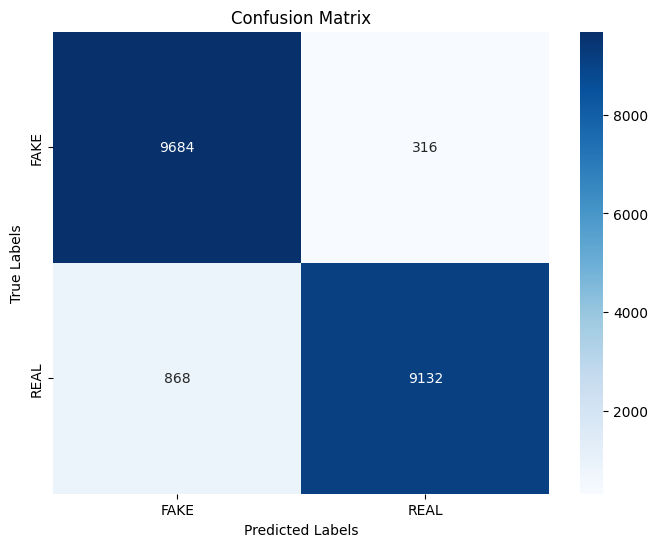

In [34]:
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

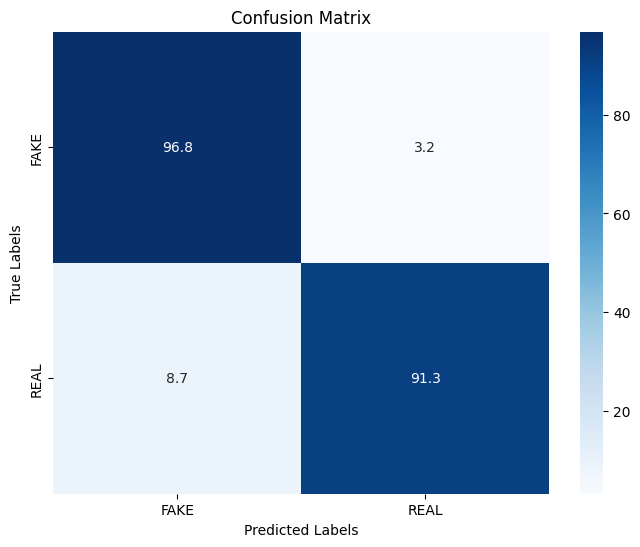

In [35]:
# Confusion matrix
cm = confusion_matrix(test_generator.labels, labels)
cm_percent = cm / cm.sum(axis=1).reshape(-1, 1) * 100

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, cmap='Blues', fmt='.1f', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
modelVGG16.save('models/VGG16_v1.h5', overwrite=True)

C:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
